# Boxplot of top five up- and downregulated genes

In [1]:
library(ggpubr)
library(ggsignif)
library(tidyverse)

Loading required package: ggplot2

-- Attaching packages --------------------------------------------------------------------------------------------------------------------- tidyverse 1.3.0 --

v tibble  3.0.6     v dplyr   1.0.4
v tidyr   1.1.2     v stringr 1.4.0
v readr   1.4.0     v forcats 0.5.1
v purrr   0.3.4     

-- Conflicts ------------------------------------------------------------------------------------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()



## Functions

In [2]:
add_symnum <- function(res){
    symnum.args <- list(cutpoints = c(0, 0.0001, 0.001, 0.01, 0.05,  1),
                        symbols = c("****", "***", "**", "*",  "ns"))
    symnum.args$x <- res$adj.P.Val
    pvalue.signif <- do.call(stats::symnum, symnum.args) %>%
    as.character()
    pvalue.format <- format.pval(res$adj.P.Val, digits = 2)
    res <- res %>%
    dplyr::ungroup() %>%
    mutate(FDR = pvalue.format, p.signif = pvalue.signif)
    return(res)
}


save_ggplots <- function(fn, p, w, h){
    for(ext in c('.pdf', '.png', '.svg')){
        ggsave(paste0(fn, ext), plot=p, width=w, height=h)
    }
}

## All genes

### Differential expressed genes

In [3]:
genes = read.delim('../../_m/genes/diffExpr_EAvsAA_full.txt')
genes = genes %>% filter(adj.P.Val < 0.05) %>%  
            select(gencodeID, ensemblID, Symbol, logFC, t, adj.P.Val)
genes = add_symnum(genes)

up_genes = genes %>% filter(t > 0) %>% mutate('Direction'='Up') %>% head(5) 
down_genes = genes %>% filter(t < 0) %>% mutate('Direction'='Down') %>% head(5) 

sig_genes = bind_rows(up_genes, down_genes) %>% mutate_at(vars(Direction), as.factor)

for(xx in seq_along(sig_genes$Symbol)){
    sig_genes$New_ID[xx] <- ifelse(sig_genes$Symbol[xx] == '', 
                                   as.character(sig_genes$ensemblID[xx]), 
                                   as.character(sig_genes$Symbol[xx]))
}
sig_genes

gencodeID,ensemblID,Symbol,logFC,t,adj.P.Val,FDR,p.signif,Direction,New_ID
<fct>,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<fct>,<chr>
ENSG00000272977.1,ENSG00000272977,,1.7114115,15.10150,1.094321e-36,< 2e-16,****,Up,ENSG00000272977
ENSG00000215374.5,ENSG00000215374,FAM66B,0.8279007,12.14406,3.378800e-25,< 2e-16,****,Up,FAM66B
ENSG00000235092.5,ENSG00000235092,ID2-AS1,0.5475301,10.83528,1.271422e-20,< 2e-16,****,Up,ID2-AS1
ENSG00000183281.14,ENSG00000183281,PLGLB1,1.0668504,10.68936,3.886432e-20,< 2e-16,****,Up,PLGLB1
ENSG00000279656.1,ENSG00000279656,,1.5496941,10.63800,5.470386e-20,< 2e-16,****,Up,ENSG00000279656
ENSG00000204894.4,ENSG00000204894,,-3.1576581,-15.86337,3.368322e-39,< 2e-16,****,Down,ENSG00000204894
ENSG00000226278.1,ENSG00000226278,PSPHP1,-4.2542502,-15.27098,4.469380e-37,< 2e-16,****,Down,PSPHP1
ENSG00000233913.7,ENSG00000233913,,-2.0425458,-15.16569,7.997721e-37,< 2e-16,****,Down,ENSG00000233913
ENSG00000230076.1,ENSG00000230076,,-3.7010407,-14.58211,1.109829e-34,< 2e-16,****,Down,ENSG00000230076


### Load residualized expression

In [4]:
res_file = '../../_m/genes/residualized_expression.tsv'
tmp_df = data.table::fread(res_file, data.table=F)

resdf0 = tmp_df %>% filter(V1 %in% sig_genes$gencodeID) %>% 
    column_to_rownames("V1")
resdf0 <- data.frame(t(resdf0))
resdf0[1:2, 1:5]

Warning message in data.table::fread(res_file, data.table = F):
"Detected 376 column names but the data has 377 columns (i.e. invalid file). Added 1 extra default column name for the first column which is guessed to be row names or an index. Use setnames() afterwards if this guess is not correct, or fix the file write command that created the file to create a valid file."


,ENSG00000235092.5,ENSG00000183281.14,ENSG00000230076.1,ENSG00000233913.7,ENSG00000226278.1
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
R11135,1.8569957,-0.6571899,-0.5034828,-0.4242666,0.5872818
R11137,0.1826202,0.5356505,-0.5846900,-0.3567665,-0.5840495


### Load pheno data

In [6]:
pheno_file = '../../../../../input/phenotypes/_m/hippo_phenotypes.csv'
pheno = read.csv(pheno_file, row.names=1) %>% mutate_if(is.character, as.factor)
levels(pheno$Race) <- c("AA", "EA")
head(pheno, 2)

,BrNum,RNum,Region,RIN,Age,Sex,Race,Dx
,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>
R11135,Br2063,R11135,HIPPO,5.9,18.77,M,CAUC,Control
R11137,Br2582,R11137,HIPPO,9.2,41.44,M,CAUC,Control


### Merge dataframe

In [6]:
resdf <- inner_join(rownames_to_column(pheno), 
                    rownames_to_column(resdf0), 
                    by="rowname")
dim(resdf)
resdf[1:2, 1:10]

[1] 376  19

,rowname,BrNum,RNum,Region,RIN,Age,Sex,Race,Dx,ENSG00000235092.5
,<chr>,<fct>,<fct>,<fct>,<dbl>,<dbl>,<fct>,<fct>,<fct>,<dbl>
1,R11135,Br2063,R11135,HIPPO,5.9,18.77,M,EA,Control,1.8569957
2,R11137,Br2582,R11137,HIPPO,9.2,41.44,M,EA,Control,0.1826202


### Melt data frame

In [8]:
df = resdf %>% select(c('rowname', 'Race', starts_with('ENSG'))) %>%
    pivot_longer(-c(rowname, Race), names_to = "gencodeID", values_to = "Res") %>%
    inner_join(sig_genes, by='gencodeID') %>% 
    mutate_at(vars("New_ID", "Symbol", "gencodeID"), as.factor)

df$New_ID = with(df, reorder(New_ID, adj.P.Val, median))
head(df, 2)

Warning message:
"Column `gencodeID` joining character vector and factor, coercing into character vector"


rowname,Race,gencodeID,Res,ensemblID,Symbol,logFC,t,adj.P.Val,FDR,p.signif,Direction,New_ID
<chr>,<fct>,<fct>,<dbl>,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<fct>,<fct>
R11135,EA,ENSG00000235092.5,1.8569957,ENSG00000235092,ID2-AS1,0.5475301,10.83528,1.271422e-20,< 2e-16,****,Up,ID2-AS1
R11135,EA,ENSG00000183281.14,-0.6571899,ENSG00000183281,PLGLB1,1.0668504,10.68936,3.886432e-20,< 2e-16,****,Up,PLGLB1


### Initial ggplot with ggpubr

Warning message:
"Ignoring unknown aesthetics: xmin, xmax, annotations, y_position"


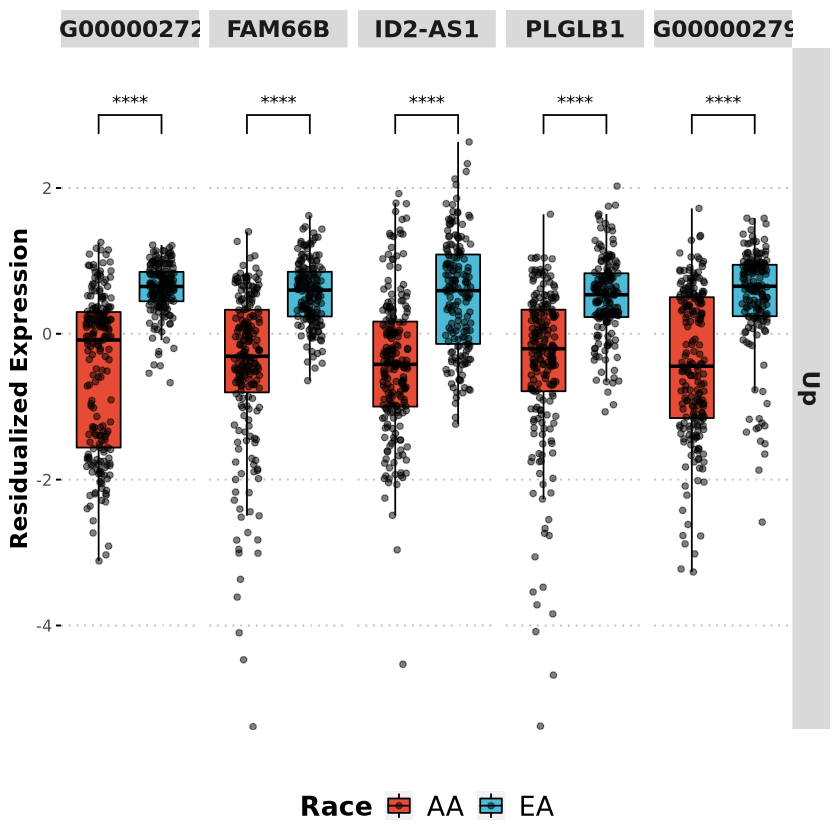

In [11]:
tmp = sig_genes %>% mutate(group1='AA', group2='EA', y_pos=3) %>% 
    filter(Direction == 'Up') %>% 
    mutate_if(is.character, as.factor)

bxp_up <- df %>% filter(Direction=="Up") %>% 
    ggboxplot(x="Race", y="Res", facet.by=c("Direction", "New_ID"), fill="Race", 
              panel.labs.font=list(face='bold', size = 14), palette="npg", xlab='',
              outlier.shape=NA, ylab='Residualized Expression', add='jitter', 
              add.params=list(alpha=0.5), legend="bottom", ylim=c(-5, 3.5), 
              ggtheme=theme_pubclean()) +
    geom_signif(data=tmp, 
                aes(xmin=group1, xmax=group2, annotations=p.signif, 
                    y_position=y_pos), 
                manual=TRUE) + 
    font("xy.title", size=14, face="bold") + 
    font("legend.title", size=16, face="bold") + 
    font("legend.text", size=16) + rremove("x.text") + rremove("x.ticks")
         
bxp_up

Warning message:
"Ignoring unknown aesthetics: xmin, xmax, annotations, y_position"


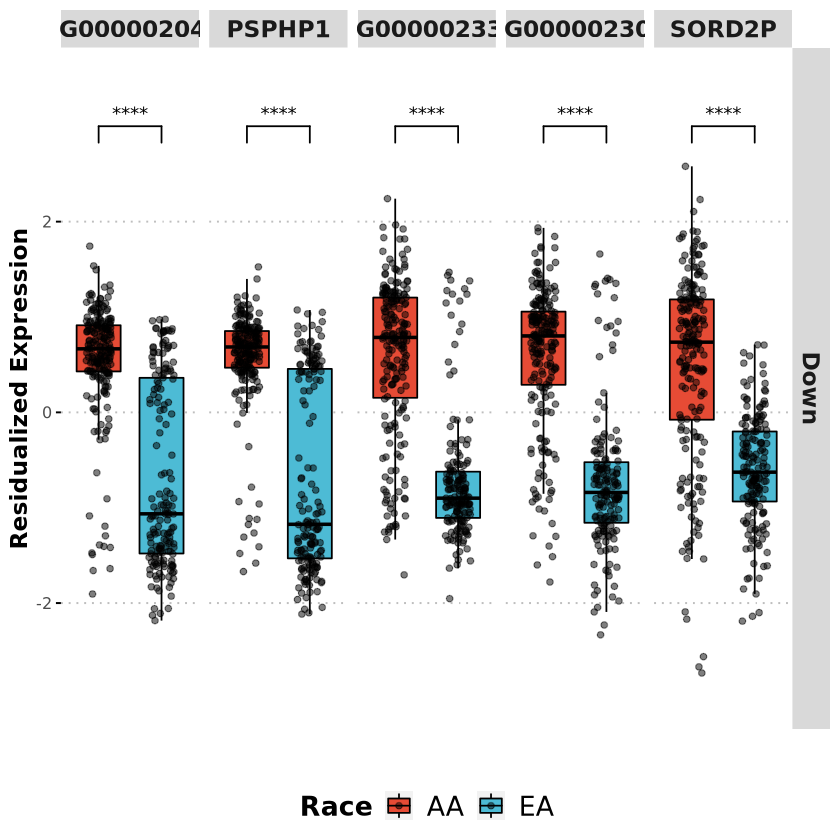

In [14]:
tmp = sig_genes %>% mutate(group1='AA', group2='EA', y_pos=3) %>% 
    filter(Direction == 'Down') %>% 
    mutate_if(is.character, as.factor)

bxp_down <- df %>% filter(Direction=="Down") %>% 
    ggboxplot(x="Race", y="Res", facet.by=c("Direction", "New_ID"), fill="Race", 
              panel.labs.font=list(face='bold', size = 14), palette="npg", xlab='',
              outlier.shape=NA, ylab='Residualized Expression', add='jitter', 
              add.params=list(alpha=0.5), legend="bottom", ylim=c(-3, 3.5), 
              ggtheme=theme_pubclean()) +
    geom_signif(data=tmp, 
                aes(xmin=group1, xmax=group2, annotations=p.signif, 
                    y_position=y_pos), 
                manual=TRUE) + 
    font("xy.title", size=14, face="bold") + 
    font("legend.title", size=16, face="bold") + 
    font("legend.text", size=16) + rremove("x.text") + rremove("x.ticks")
         
bxp_down

### Annotate figure

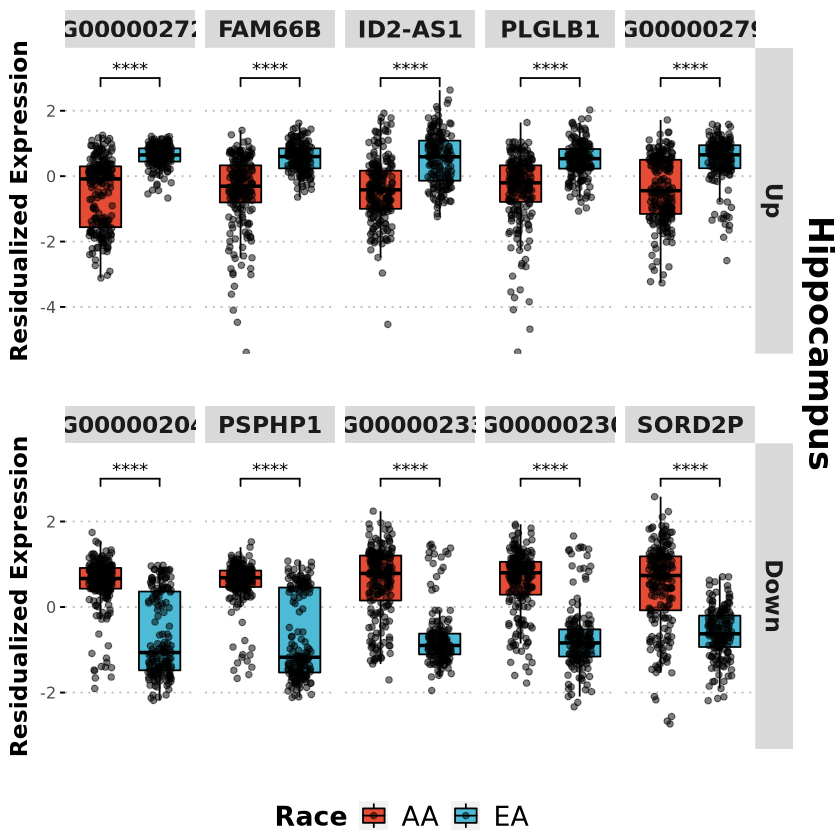

In [15]:
figure <- ggarrange(bxp_up, bxp_down, ncol=1, nrow=2, 
                    common.legend=TRUE, legend="bottom")
figure <- annotate_figure(figure, right=text_grob("Hippocampus", size=20, 
                                                  rot=-90, face='bold', hjust=0.8))
figure

In [15]:
save_ggplots('hippocampus_topSig_boxplot', figure, 12, 9)

## Session Info

In [ ]:
Sys.time()
proc.time()
options(width = 120)
sessioninfo::session_info()